**COVID19 CT Pneumonia Detection**
with Transfer Learning: An implementation in Tensorflow and Keras

In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
from numpy.random import seed
seed(8) #1

import tensorflow
tensorflow.random.set_seed(7) #2

#seed for applying random image augmentation and shuffling the order of the image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


In [163]:
print(os.listdir("D:/MASTER/SEM2/AI/PROJECT/TL/COVID19_Detection_TL_Dataset_Update/two"))

['test', 'train']


In [164]:
from os import listdir
data_list = listdir('D:/MASTER/SEM2/AI/PROJECT/TL/COVID19_Detection_TL_Dataset_Update/two/train')

data_list

['covid', 'normal']

Case 1: COVID vs Normal
VGG Initialization

In [165]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf


DATASET_PATH  = 'D:/MASTER/SEM2/AI/PROJECT/TL/COVID19_Detection_TL_Dataset_Update/two/train'
test_dir =  'D:/MASTER/SEM2/AI/PROJECT/TL/COVID19_Detection_TL_Dataset_Update/two/test'
IMAGE_SIZE    = (150, 150) 
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # No. of images to be yielded from the generator per batch (try reducing batch size or freeze more layers if your GPU runs out of memory)
NUM_EPOCHS    = 10 # The maximum number of times the program can iterate over the entire dataset in one train
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 #5e-4



#setup the respective training and validation preprocessing and batch image preparation 
#functions using the ImageDataGenerator class, specifying our class_mode parameter as “binary” for this case
#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary",
                                                 
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary",
                                                  
                                                 
                                                  )



C:\Users\Admin\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


Layer Modification at upper layer of VGG16

In [166]:
#Simple CNN model based on VGG16


from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))   #Rectified Linear Unit
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid activation function


model.compile(loss='binary_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [167]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


Training

In [168]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,
                         
                       )



11
3
Epoch 1/10


C:\Users\Admin\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Admin\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/10 [==============================] - 7s 669ms/step - loss: 0.9135 - acc: 0.5745 - val_loss: 0.4761 - val_acc: 0.6500
Epoch 2/10
10/10 [==============================] - 6s 585ms/step - loss: 0.4783 - acc: 0.7400 - val_loss: 0.4773 - val_acc: 0.6875
Epoch 3/10
10/10 [==============================] - 5s 548ms/step - loss: 0.2307 - acc: 0.9432 - val_loss: 0.1779 - val_acc: 0.8750
Epoch 4/10
10/10 [==============================] - 6s 560ms/step - loss: 0.2336 - acc: 0.9149 - val_loss: 0.2783 - val_acc: 0.9000
Epoch 5/10
10/10 [==============================] - 5s 544ms/step - loss: 0.2390 - acc: 0.9043 - val_loss: 0.2475 - val_acc: 0.8750
Epoch 6/10
10/10 [==============================] - 5s 520ms/step - loss: 0.1845 - acc: 0.9468 - val_loss: 0.1163 - val_acc: 0.9375
Epoch 7/10
10/10 [==============================] - 5s 542ms/step - loss: 0.2359 - acc: 0.9043 - val_loss: 0.0766 - val_acc: 0.9500
Epoch 8/10
10/10 [==============================] - 6s 578ms/step - loss: 0.2170 - acc:

Evaluation

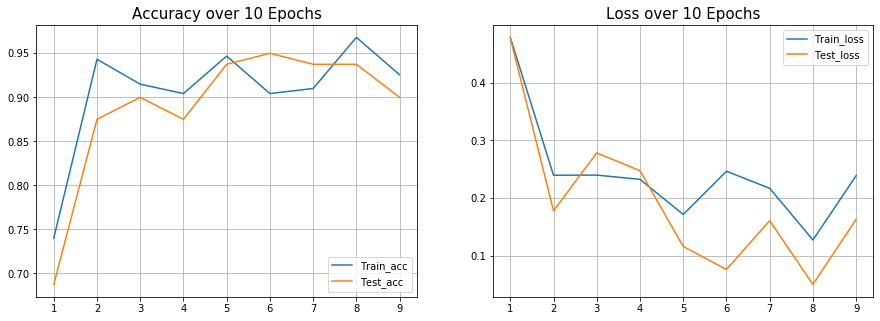

In [169]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 10)

In [170]:
model.save('Covid_Binary_VGG16_two.h5')

In [171]:
#Dont forget shuffle false. Note that Shuffle False is necessary for predict generator due to Keras's internal shuffling.

test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,
        
        
        class_mode="binary")
eval_generator.reset()    



Found 11 images belonging to 2 classes.


In [172]:

eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])



2/2 [==============================] - 0s 110ms/step
Test loss: 0.6937450766563416
Test accuracy: 0.0


Predict

In [173]:
eval_generator.reset()  
pred = model.predict_generator(eval_generator,1000,verbose=1)
print("Predictions finished")






1000/1000 [==============================] - 67s 67ms/step
Predictions finished


covid\nejmoa2001191_f4.jpeg


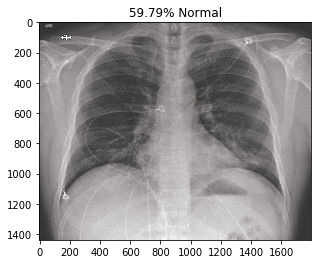

covid\nejmoa2001191_f5-PA.jpeg


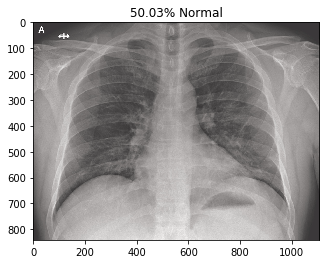

covid\radiol.2020200490.fig3.jpeg


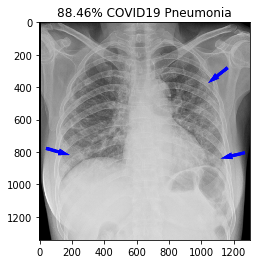

covid\ryct.2020200034.fig2.jpeg


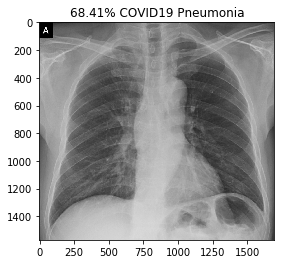

covid\ryct.2020200034.fig5-day0.jpeg


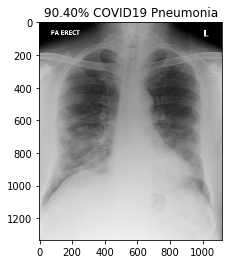

covid\ryct.2020200034.fig5-day4.jpeg


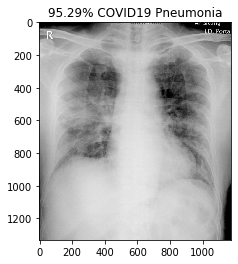

normal\NORMAL2-IM-1385-0001.jpeg


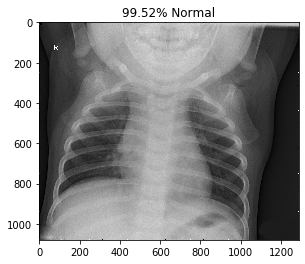

normal\NORMAL2-IM-1396-0001.jpeg


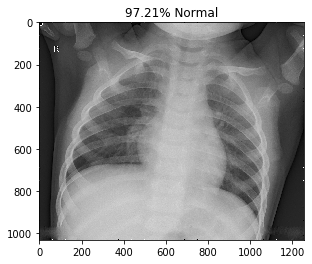

normal\NORMAL2-IM-1400-0001.jpeg


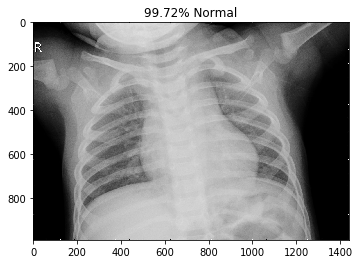

normal\NORMAL2-IM-1401-0001.jpeg


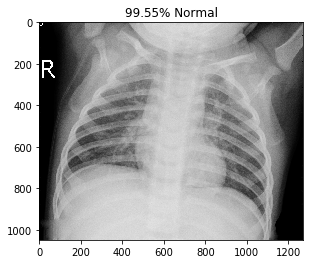

normal\NORMAL2-IM-1422-0001.jpeg


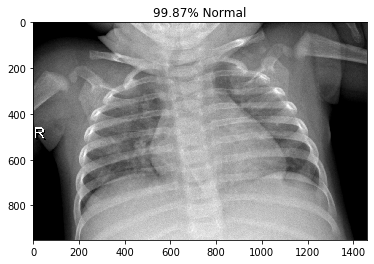

IndexError: list index out of range

In [174]:
import cv2


import matplotlib.image as mpimg
for index, probability in enumerate(pred):
    image_path = test_dir + "/" + eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [175]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [177]:
cm = confusion_matrix(eval_generator, train_batches)

ValueError: Expected array-like (array or non-string sequence), got <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x00000243020F79B0>

In [154]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
    
    print(cm)
    

In [125]:
cm_plot_labels = ['Normal','COVID19 Pneumonia']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

NameError: name 'cm' is not defined